In [1]:
import sys
# Append the previous directory to the path
sys.path.append('../')

In [2]:
from counterplots import CreatePlot

In [3]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from alibi.explainers import CounterfactualProto

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

2023-05-08 12:04:20.129878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 12:04:21.189845: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64
2023-05-08 12:04:21.190180: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64
2023-05-08 12:04:21.190200: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:3

TF version:  2.11.0
Eager execution enabled:  False


In [4]:
# Get data
california = fetch_california_housing(as_frame=True)
X = california.data.to_numpy()
target = california.target.to_numpy()
feature_names = california.feature_names

In [5]:
# Make label treatment
y = np.zeros((target.shape[0],))
y[np.where(target > np.median(target))[0]] = 1

In [6]:
# Get dataset info
mu = X.mean(axis=0)
sigma = X.std(axis=0)
X = (X - mu) / sigma

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

In [9]:
def nn_model():
    x_in = Input(shape=(8,))
    x = Dense(40, activation='relu')(x_in)
    x = Dense(40, activation='relu')(x)
    x_out = Dense(2, activation='softmax')(x)
    nn = Model(inputs=x_in, outputs=x_out)
    nn.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return nn

In [10]:
nn = nn_model()
nn.summary()
nn.fit(X_train, y_train, batch_size=64, epochs=500, verbose=0)
nn.save('nn_california.h5', save_format='h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 40)                360       
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 2)                 82        
                                                                 
Total params: 2,082
Trainable params: 2,082
Non-trainable params: 0
_________________________________________________________________


2023-05-08 12:04:24.544835: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 12:04:24.545436: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-08 12:04:24.545970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-08 12:04:24.546462: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [11]:
nn = load_model('nn_california.h5')
score = nn.evaluate(X_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

2023-05-08 12:07:42.062818: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_1_1/bias/Assign' id:299 op device:{requested: '', assigned: ''} def:{{{node dense_1_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1_1/bias, dense_1_1/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-08 12:07:42.181017: W tensorflow/c/c_api.cc:291] Operation '{name:'total_1/Assign' id:356 op device:{requested: '', assigned: ''} def:{{{node total_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_1, total_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modif

Test accuracy:  0.87645346


In [12]:
def CounterPlotAlibic(factual, exp, model):
    factual=factual.round(3).astype('float32')
    cf = exp.cf['X'][0].round(3).astype('float32')
    
    out_exp = CreatePlot(
        factual=factual,
        cf=cf,
        model_pred=model,
        feature_names=['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
    )
    
    return out_exp

In [13]:
X = X_test[1].reshape((1,) + X_test[1].shape)
shape = X.shape

In [14]:
# define model
nn = load_model('nn_california.h5')

# initialize and fit the explainer
cf = CounterfactualProto(nn, shape, use_kdtree=True, theta=10., max_iterations=1000,
                         feature_range=(X_train.min(axis=0), X_train.max(axis=0)),
                         c_init=1., c_steps=10)

cf.fit(X_train)

2023-05-08 12:07:42.651381: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_4/kernel/Assign' id:475 op device:{requested: '', assigned: ''} def:{{{node dense_4/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_4/kernel, dense_4/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-08 12:07:42.778816: W tensorflow/c/c_api.cc:291] Operation '{name:'total_2/Assign' id:558 op device:{requested: '', assigned: ''} def:{{{node total_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_2, total_2/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either do

CounterfactualProto(meta={
  'name': 'CounterfactualProto',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'kappa': 0.0,
              'beta': 0.1,
              'gamma': 0.0,
              'theta': 10.0,
              'cat_vars': None,
              'ohe': False,
              'use_kdtree': True,
              'learning_rate_init': 0.01,
              'max_iterations': 1000,
              'c_init': 1.0,
              'c_steps': 10,
              'eps': (0.001, 0.001),
              'clip': (-1000.0, 1000.0),
              'update_num_grad': 1,
              'write_dir': None,
              'feature_range': (array([-1.77429947, -2.19618048, -1.83504572, -1.61076772, -1.25612255,
       -0.22899997, -1.44288613, -2.38599234]), array([  5.85828581,   1.85618152,  55.16323628,  51.78248741,
        30.25033022, 119.41910319,   2.95806762,   2.62528006])),
              'shape': (1, 8),
              'is_model': True,
              '

In [15]:
def adapted_predict(x):
    prediction = np.array(nn.predict(np.array(x)))
    # Return [class0, class1] for each instance
    return prediction


In [21]:
X = X_test[1].reshape((1,) + X_test[1].shape)

In [22]:
cf_alibic = cf.explain(X)
exp_alibic = CounterPlotAlibic(X[0], cf_alibic, adapted_predict)

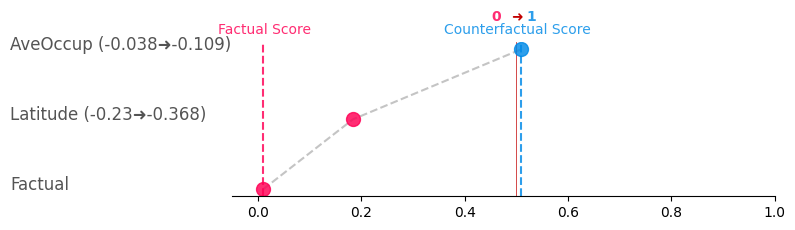

In [23]:
exp_alibic.greedy()

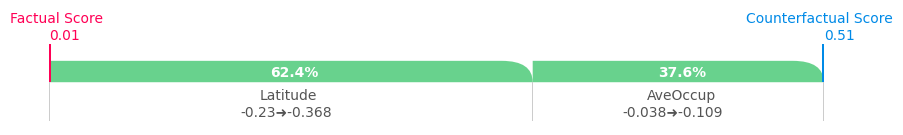

In [24]:
exp_alibic.countershapley()

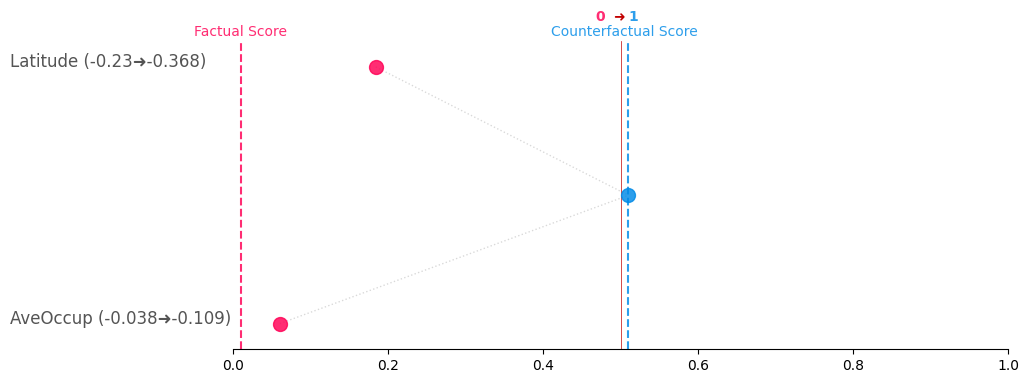

In [25]:
exp_alibic.constellation()